In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

Forecast the time series of interest y assuming that it has a linear relationship with other time series x.

### assumptions about the errors:
1. they have mean zero, otherwise the forecasts will be systematically biased.
2. they are not autocorrealted; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
3. they are unrelated to the predictor variables; otherwise there would be more information that should be inclueded in the systematic part of the model.
4. it is also useful to have the errors being normally distributed with a constant variance σ² in order to easily produce prediction intervals.

1. 合理的模型：线性回归模型假设它是与现实情况合理近似的模型；也就是说，预测变量与解释变量之间的关系满足线性方程。
2. 均值为零的误差：模型中的误差（表示为ε1、ε2、...、εT）被假定具有零均值。这意味着从平均角度来看，模型的预测是准确的。如果误差具有非零均值，则表明预测存在系统偏差。
3. 无自相关性：误差被假定不具有自相关性，也就是说误差之间不应该存在系统模式或相关性。自相关性可能会导致预测低效，因为这意味着数据中仍然存在未被模型捕捉的更多信息。
4. 误差与解释变量无关：误差被假定与解释变量无关。换句话说，解释变量的值不应与误差存在系统关系。如果存在这种关系，将意味着在模型的系统部分应该包括更多信息。
正态分布且方差恒定：理想情况下，误差应该服从正态分布，并且具有恒定的方差（σ²）。这个假设有助于生成预测区间和进行某些统计检验。
5. 解释变量非随机：假设每个解释变量（x）都不是随机变量。在控制实验中，解释变量的值可以被控制并观察。然而，在观测数据中（在业务和经济领域中很常见），假设解释变量的值不受直接控制，而是观察到它们自然发生。

In [49]:
def load_data(file_path):
    data = pd.read_csv(file_path)

    data = data.set_index('Date')
    data.index = pd.to_datetime(data.index)

    y=data['forward_return_3']
    X = data.drop('forward_return_3', axis=1)

    return X, y

X_train, y_train = load_data('train_set.csv')
X_validation, y_validation = load_data('validation_set.csv')

/var/folders/cn/ml3np26x7lx32rq6thnw223r0000gn/T/ipykernel_55727/2037973170.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data.index = pd.to_datetime(data.index)


In [50]:
X_train = pd.concat([X_train, X_validation], axis=0)
y_train = pd.concat([y_train, y_validation], axis=0)

In [51]:
X_train.head(5)

,forward_return_1,return_1,return_3,forward_return_5,return_5,forward_return_10,volatility_5,volatility_10,volatility_20,ADX,...,APO,AROONOSC,BOP,CCI,MOM,RSI,ULTOSC,MA,NATR,TRANGE
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-27 00:00:00+00:00,0.012298,0.005722,0.013567,0.017736,0.013739,0.027023,0.086914,0.071347,0.070490,33.033953,...,1.168974,92.857143,0.706665,129.856084,3.049996,74.906646,61.169965,0.878667,0.814917,0.800004
1997-01-28 00:00:00+00:00,0.000000,0.012298,0.015101,0.012066,0.026468,0.018843,0.103690,0.086481,0.078599,35.663247,...,1.309167,100.000000,0.636365,176.284745,4.059998,49.597916,59.582255,0.967000,0.878567,2.220001
1997-01-29 00:00:00+00:00,0.006198,0.000000,0.018090,0.020578,0.026032,0.018843,0.104971,0.084466,0.078425,38.104734,...,1.431987,85.714286,0.000000,149.505604,4.230003,49.597916,58.708096,1.044333,0.815812,0.000000
1997-01-30 00:00:00+00:00,-0.004107,0.006198,0.018573,0.016838,0.021393,0.020370,0.094062,0.079237,0.078223,40.787949,...,1.558974,100.000000,-0.363635,145.421133,0.029999,49.597916,58.398620,1.100000,0.849676,1.650002
1997-01-31 00:00:00+00:00,0.003299,-0.004107,0.002066,0.015670,0.020194,0.024742,0.099888,0.088473,0.080164,43.279505,...,1.687307,92.857143,-0.632353,115.035632,3.930000,76.266813,53.755397,1.166667,0.872356,1.360001


# 1. linear relationship between X_train and y_train

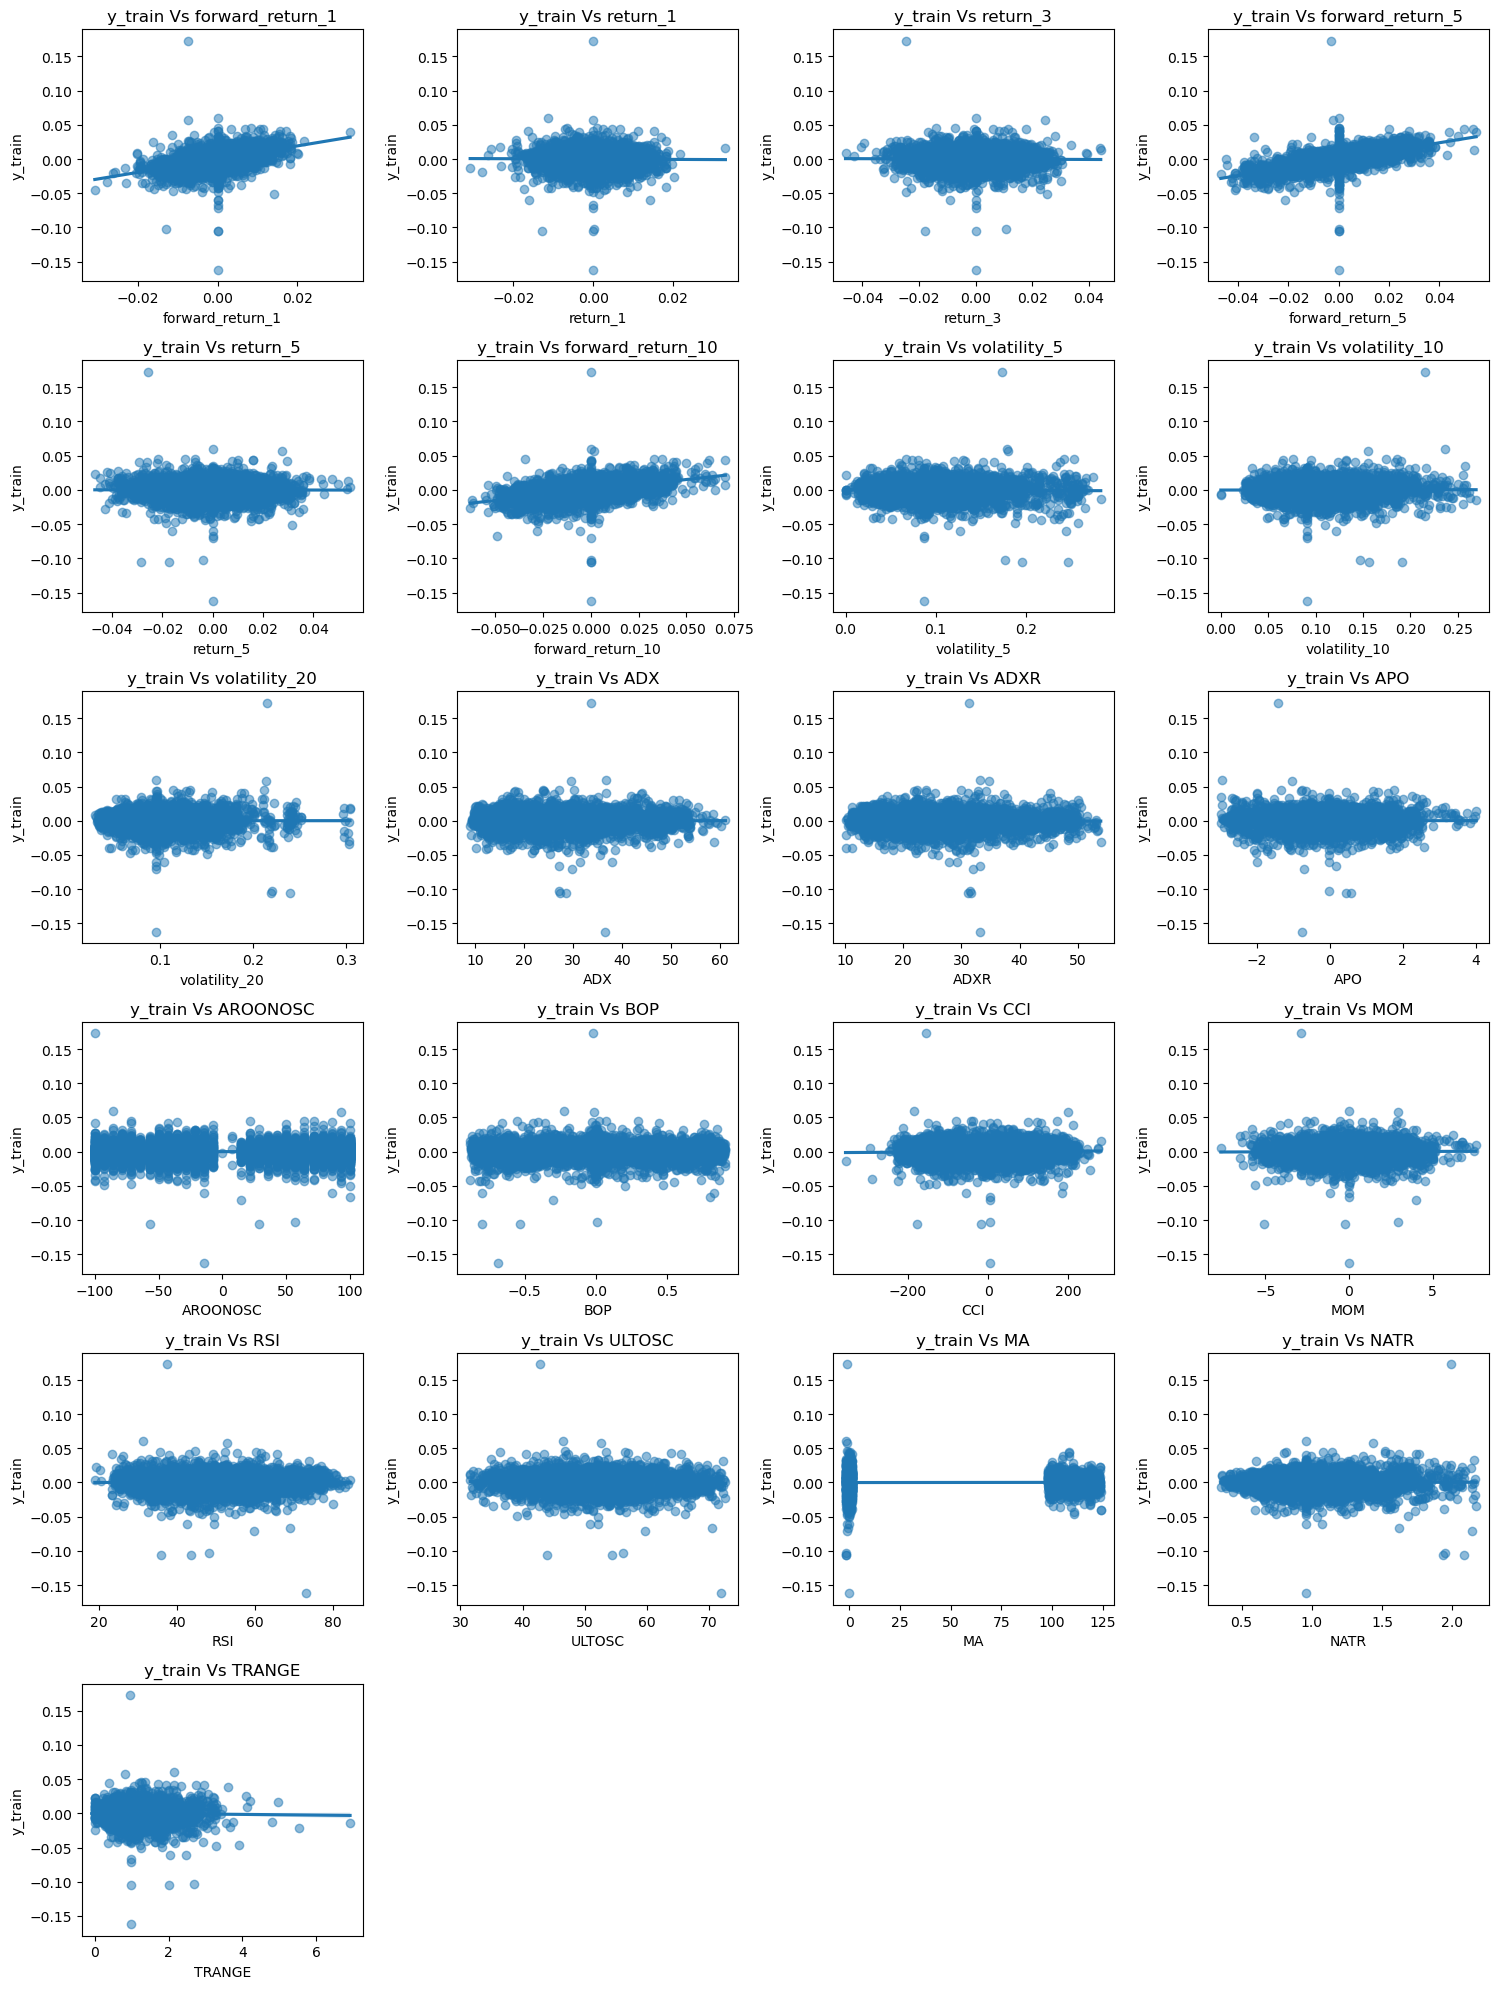

In [52]:
import math


n_cols = 4
n_rows = math.ceil(X_train.shape[1] / n_cols)

plt.figure(figsize=(15, 20))

for i, column in enumerate(X_train.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.regplot(x=X_train[column], y=y_train, scatter_kws={'alpha':0.5})
    plt.xlabel(column)
    plt.ylabel('y_train')
    plt.title(f"y_train Vs {column}")

plt.tight_layout()
plt.show()


opps! majority of the features don't have linear relationship with target. This indicates that using linear regression has a high risk of inaccurate predictions and overfitting.

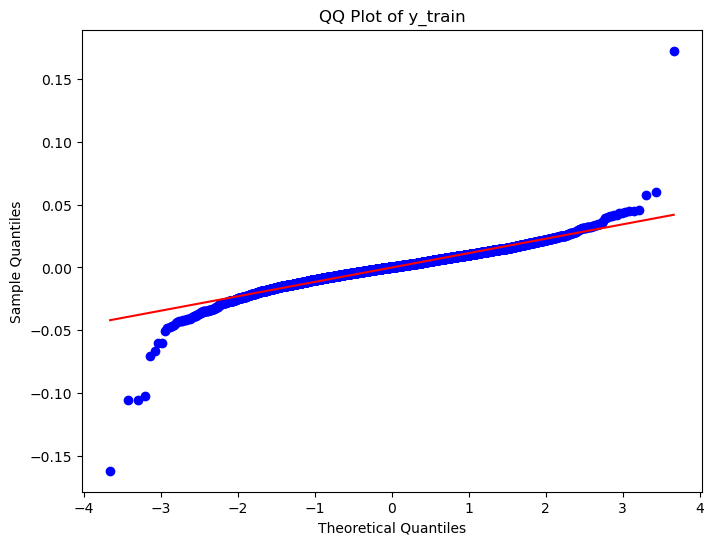

In [53]:
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(y_train, dist="norm", plot=plt)
plt.title("QQ Plot of y_train")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


In [54]:
from scipy.stats import boxcox
y_train_boxcox, lambda_value = boxcox(y_train + 1)  

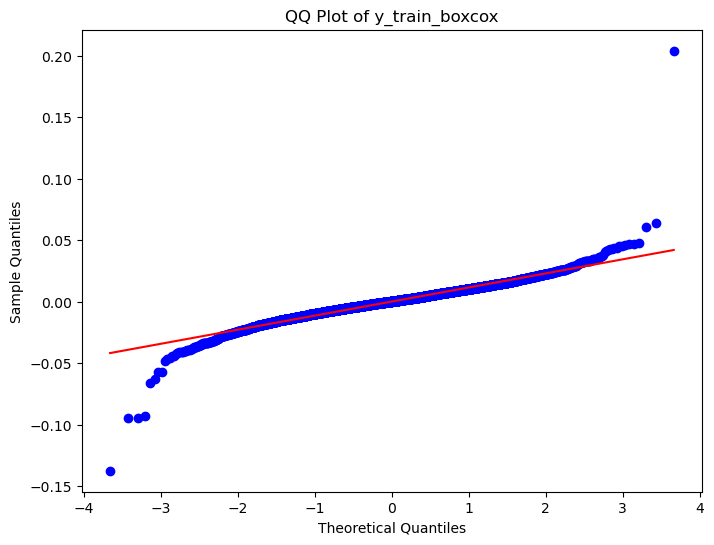

In [55]:
plt.figure(figsize=(8, 6))
stats.probplot(y_train_boxcox, dist="norm", plot=plt)
plt.title("QQ Plot of y_train_boxcox")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

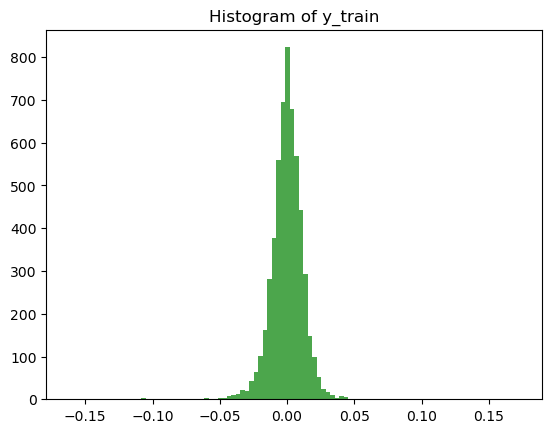

In [56]:
plt.hist(y_train,bins =100, color='green', alpha=0.7)
plt.title('Histogram of y_train')
plt.show()

it tells the distribution of target has a high kurtosis with fat-tails.

/Users/ryliu/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ryliu/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ryliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


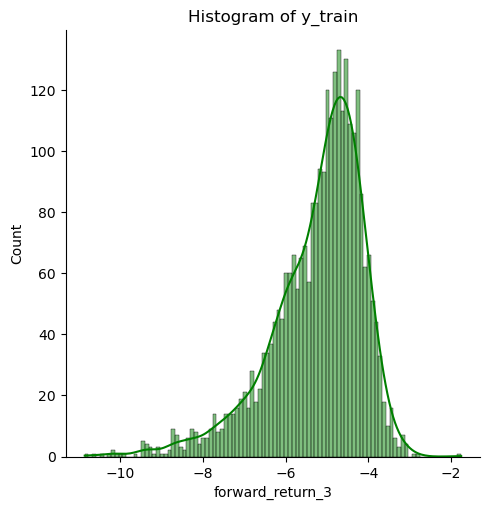

In [57]:
# log -normalize
y_train_log = np.log(y_train)

sns.displot(y_train_log,bins =100, kde=True, color='green')
plt.title('Histogram of y_train')
plt.show()

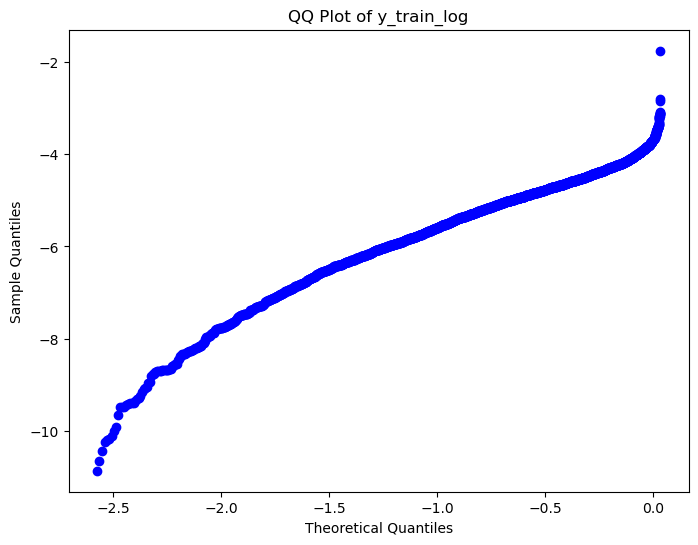

In [58]:
plt.figure(figsize=(8, 6))
stats.probplot(y_train_log, dist="norm", plot=plt)
plt.title("QQ Plot of y_train_log")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

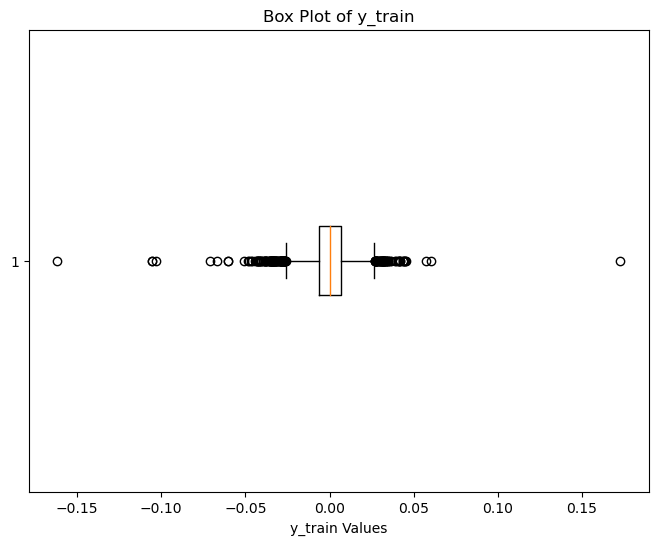

In [59]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(8, 6))
plt.boxplot(y_train, vert=False)
plt.title('Box Plot of y_train')
plt.xlabel('y_train Values')
plt.show()

In [60]:
outliers = (y_train < lower_bound) | (y_train > upper_bound)
median_value = np.median(y_train)
y_train_copied = y_train.copy()
y_train_copied[outliers] = median_value

/Users/ryliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


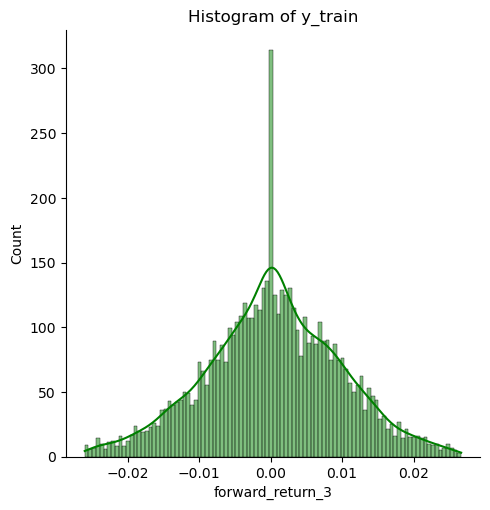

In [61]:
sns.displot(y_train_copied,bins =100, kde=True, color='green')
plt.title('Histogram of y_train')
plt.show()

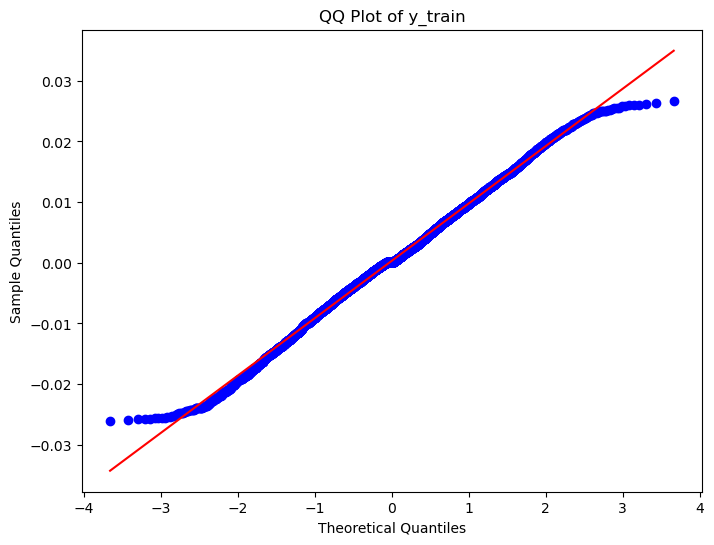

In [62]:
plt.figure(figsize=(8, 6))
stats.probplot(y_train_copied, dist="norm", plot=plt)
plt.title("QQ Plot of y_train")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

after several transforms, it seems the original one is the closest one to the normal distribution, hence I will use the original y_train

# The first version

In [63]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)

print(f"coef: {model.coef_}")
print(f"bias: {model.intercept_:.3f}")
print(f"R2: {model.score(X_train, y_train):.3f}")

coef: [ 5.00312350e-01 -1.34317424e-02 -2.69759222e-02  4.70503466e-01
  1.13124184e-02  3.57387176e-02 -1.02804009e-02  1.66530784e-02
 -8.55340198e-03  2.19931016e-05 -1.79832077e-05  3.80607304e-04
 -2.13253598e-06  5.65858793e-04  5.97987316e-06  2.72243437e-05
 -5.71515067e-05 -2.61081986e-05  1.90416272e-06  1.97034669e-04
 -1.20136125e-04]
bias: 0.004
R2: 0.490


In [64]:
X_test, y_test = load_data('test_set.csv')

/var/folders/cn/ml3np26x7lx32rq6thnw223r0000gn/T/ipykernel_55727/2037973170.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data.index = pd.to_datetime(data.index)


In [65]:
y_pred = model.predict(X_test)

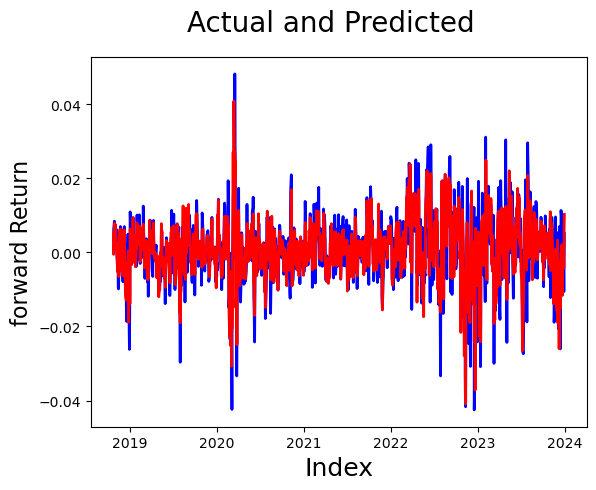

In [66]:
fig = plt.figure()
plt.plot(y_test.index,y_test, color="blue", linewidth=2, linestyle="-")
plt.plot(y_test.index,y_pred, color="red",  linewidth=2, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              
plt.xlabel('Index', fontsize=18)                               
plt.ylabel('forward Return', fontsize=16)
plt.show()

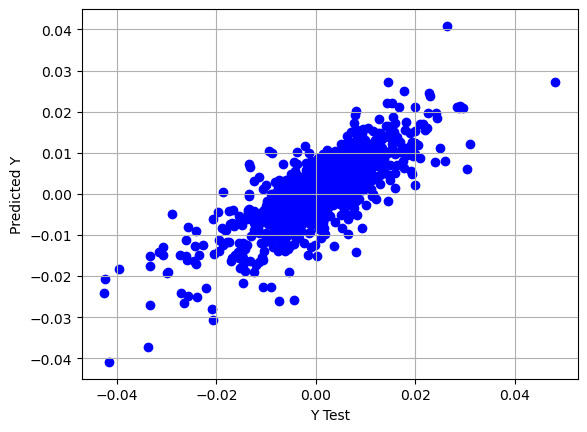

In [67]:
plt.scatter(y_test,y_pred,c='blue')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.grid()

very bad solution,and obvious overfitting

In [68]:
#mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

MAE = mean_absolute_error(y_test, y_pred)
MAE

0.003942395453081451

In [69]:
MSE = mean_squared_error(y_test, y_pred)
MSE

3.0167216175285878e-05

In [70]:
RMSE =  np.sqrt(mean_squared_error(y_test, y_pred))
RMSE

0.005492469041814062

In [71]:
R2 = r2_score(y_test, y_pred)
R2

0.644684639213935

/var/folders/cn/ml3np26x7lx32rq6thnw223r0000gn/T/ipykernel_55727/569804710.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred),bins = 100,color='b')
/Users/ryliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


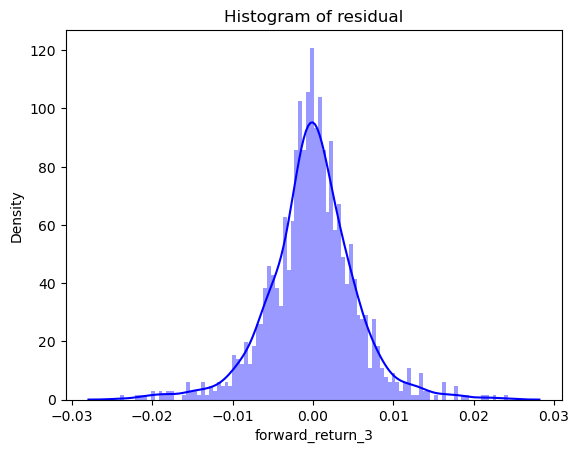

In [72]:
sns.distplot((y_test - y_pred),bins = 100,color='b')
plt.title('Histogram of residual')
plt.show()

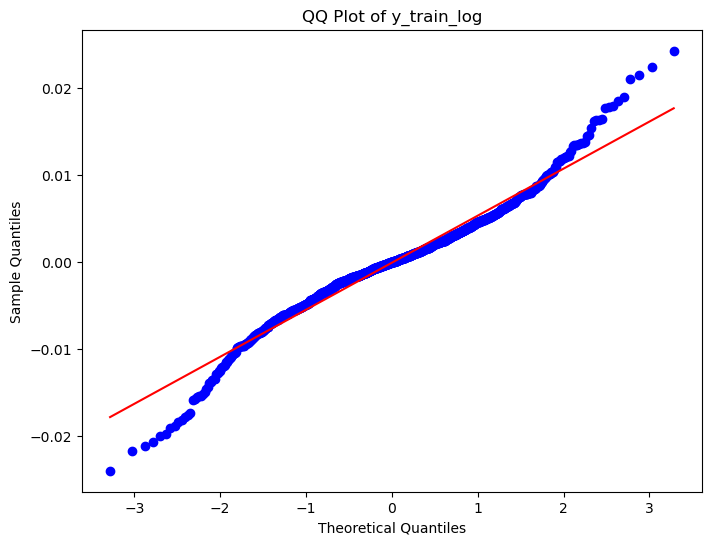

In [73]:
plt.figure(figsize=(8, 6))
stats.probplot((y_test-y_pred), dist="norm", plot=plt)
plt.title("QQ Plot of y_train_log")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# Refine the model

## Principal component analysis

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for column in X_train.columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1,1))

In [82]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)

array([[-4.22045921,  0.83363666,  2.43502721, ..., -0.26408285,
        -0.01064695,  0.49055325],
       [-3.80118347,  2.33243848,  0.83473152, ...,  0.88167083,
        -0.94259138, -1.40206773],
       [-3.54008234,  0.720643  ,  2.0219328 , ...,  0.66773608,
        -1.07143361, -1.21714256],
       ...,
       [-3.63420335, -0.77533595, -1.22674713, ..., -0.51157554,
        -0.31060171,  0.42777302],
       [-2.70440064, -1.35158732, -1.33958601, ..., -0.70950918,
        -0.11334096,  0.30327124],
       [-1.87028176, -1.2682426 , -1.51763447, ..., -0.46036791,
        -0.21203013,  0.14585853]])

In [83]:
pca.get_covariance()

array([[ 1.00018064e+00, -2.73804730e-02, -2.27611793e-02,
         4.12272660e-01, -1.66122204e-02,  2.90149006e-01,
        -4.73494448e-03, -8.11012660e-03,  1.49210281e-02,
        -4.37435904e-03, -1.01608661e-02,  1.54912007e-02,
         3.79586630e-02, -2.01570565e-02,  5.26465386e-02,
         7.79200495e-03,  3.90127479e-03, -9.45768034e-02,
         2.29468098e-03,  6.23820220e-03, -1.60429560e-02],
       [-2.73804730e-02,  1.00018064e+00,  4.99578831e-01,
        -9.41839476e-03,  3.96113382e-01,  6.99770141e-03,
        -2.45899784e-02, -1.35454598e-02,  9.19433005e-03,
        -4.97167194e-03, -1.09572416e-02,  4.10676515e-02,
         1.29687351e-01,  6.89124712e-01,  3.67123125e-01,
         2.77302997e-01,  3.17206334e-01,  2.00031099e-01,
         2.37484889e-03, -1.98642509e-02, -3.81396913e-02],
       [-2.27611793e-02,  4.99578831e-01,  1.00018064e+00,
        -6.34914526e-04,  7.03843255e-01,  1.73341496e-02,
        -5.02515519e-02, -2.61747817e-02, -1.02051714e

In [84]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.25506158, 0.1699886 , 0.09267488, 0.08233477, 0.07469973,
       0.04727244, 0.04528316, 0.03795628, 0.0316605 , 0.02968971,
       0.02293052, 0.01920327, 0.01519925, 0.01357739, 0.01290262,
       0.01081722, 0.00992731, 0.00856729, 0.00771488, 0.00716426,
       0.00537433])

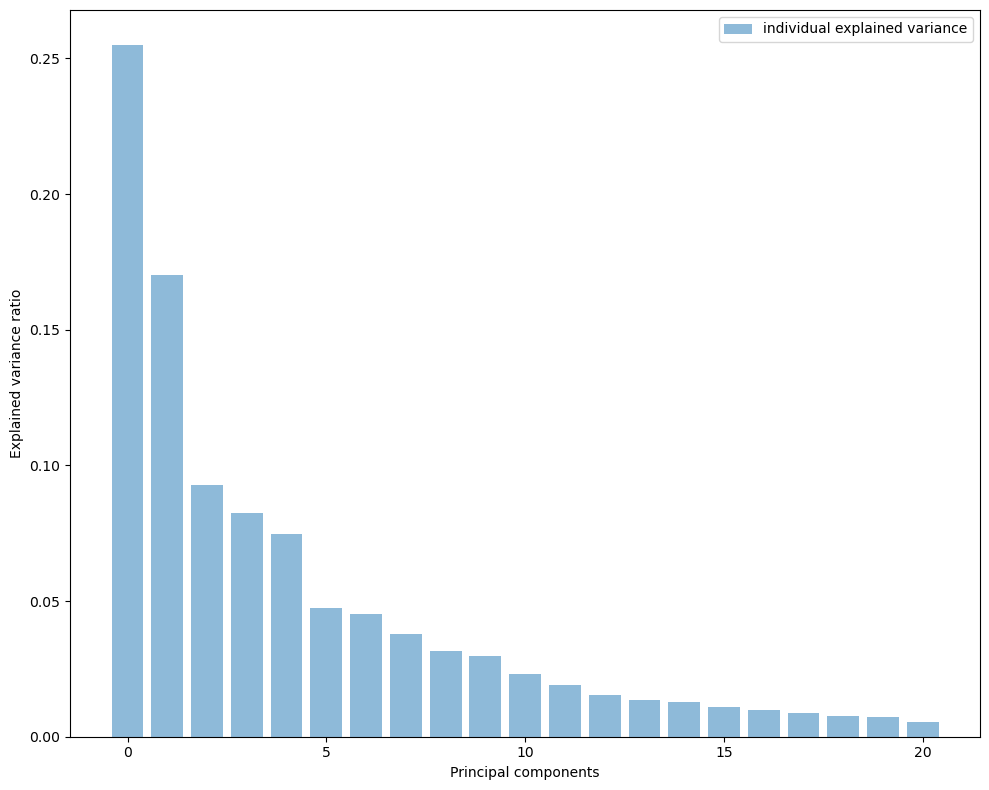

In [86]:
plt.figure(figsize=(10,8))

plt.bar(range(21), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [94]:
pca = PCA(n_components= 8)
X_new = pca.fit_transform(X_train)
X_new

array([[-4.22045929,  0.83363673,  2.43503809, ..., -0.27568181,
         1.30585256, -0.58144398],
       [-3.80118302,  2.33243731,  0.8346646 , ...,  0.12231323,
         0.92301045,  0.69062016],
       [-3.54008189,  0.72064158,  2.02186778, ..., -1.31446472,
        -0.65721042, -0.32439412],
       ...,
       [-3.63420338, -0.77533702, -1.22673527, ...,  1.5702287 ,
        -0.64075522, -0.70015809],
       [-2.70440074, -1.35158911, -1.33955205, ...,  1.34796995,
        -0.78579988, -0.48086688],
       [-1.87028183, -1.26824455, -1.51760453, ...,  1.67369629,
        -0.26630633,  1.26555407]])

In [90]:
model = LinearRegression(fit_intercept=True)

model.fit(X_new, y_train)

print(f"coef: {model.coef_}")
print(f"bias: {model.intercept_:.3f}")
print(f"R2: {model.score(X_new, y_train):.3f}")

coef: [-3.14708235e-05 -5.19871588e-05  5.69639739e-03 -8.49372379e-04
  4.36171888e-04  3.69021207e-05  3.33934489e-04 -7.57098002e-04]
bias: -0.000
R2: 0.457


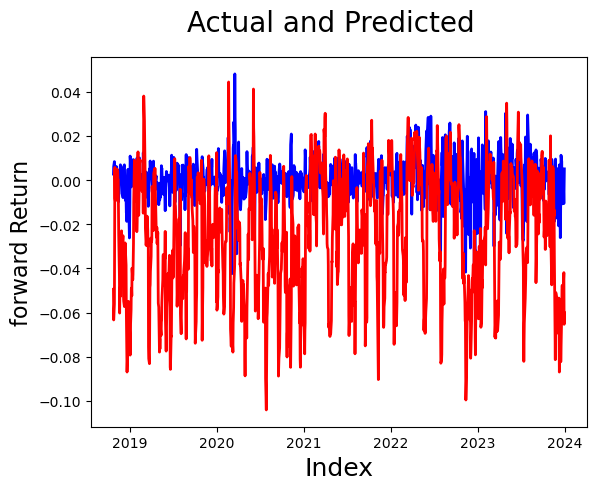

In [95]:
X_test_new = pca.transform(X_test)

y_pred = model.predict(X_test_new)

fig = plt.figure()
plt.plot(y_test.index,y_test, color="blue", linewidth=2, linestyle="-")
plt.plot(y_test.index,y_pred, color="red",  linewidth=2, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              
plt.xlabel('Index', fontsize=18)                               
plt.ylabel('forward Return', fontsize=16)
plt.show()

In [96]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.030139878531699704

In [97]:
MSE = mean_squared_error(y_test, y_pred)
MSE

0.0014392575217626797

In [98]:
RMSE =  np.sqrt(mean_squared_error(y_test, y_pred))
RMSE

0.03793754765087854

In [99]:
R2 = r2_score(y_test, y_pred)
R2

-15.951856035961136

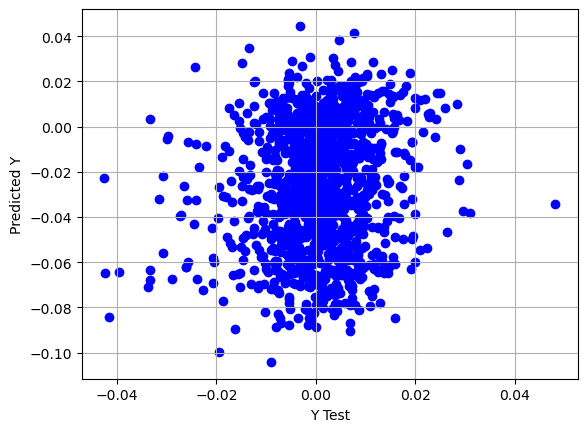

In [100]:
plt.scatter(y_test,y_pred,c='blue')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.grid()

/var/folders/cn/ml3np26x7lx32rq6thnw223r0000gn/T/ipykernel_55727/569804710.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred),bins = 100,color='b')
/Users/ryliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


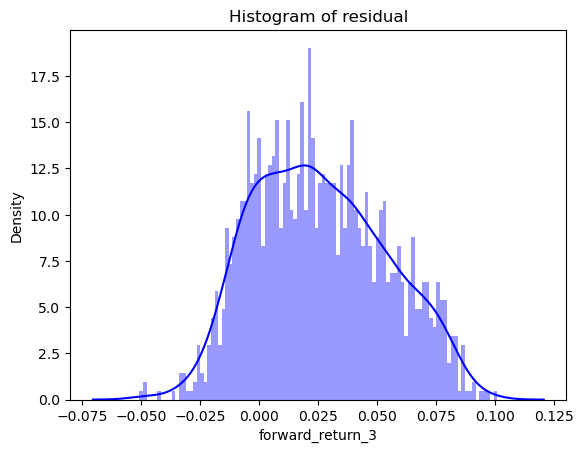

In [101]:
sns.distplot((y_test - y_pred),bins = 100,color='b')
plt.title('Histogram of residual')
plt.show()

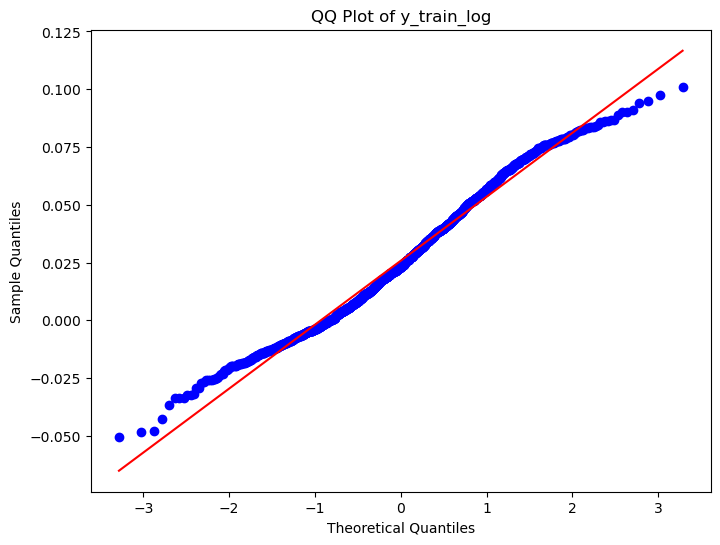

In [102]:
plt.figure(figsize=(8, 6))
stats.probplot((y_test-y_pred), dist="norm", plot=plt)
plt.title("QQ Plot of y_train_log")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


### Reasons for Decreased Predictive Performance:

Information Loss: One of the goals of PCA is to reduce the dimensionality of data by projecting the original features onto principal components. However, during the dimensionality reduction process, some information may be lost. If the principal components contain important information from the original data, and you retain a smaller number of principal components, the model may fail to capture sufficient information for accurate predictions.

Principal Components Are Not Necessarily the Most Relevant: PCA creates principal components by linearly combining the original features, and these principal components are typically uncorrelated. However, in some cases, the relationships between the original features may not be linear but nonlinear. This means that PCA may not capture these nonlinear relationships, leading to a decrease in model performance.

Influence of Noise: If the original data contains noise or outliers, PCA may amplify these noise components, resulting in undesired information being included in the principal components. This can negatively affect the model's performance.

Parameter Selection: PCA involves selecting certain parameters, such as the number of principal components to retain. Improper parameter choices can lead to a decrease in performance.